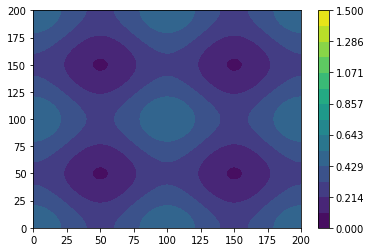

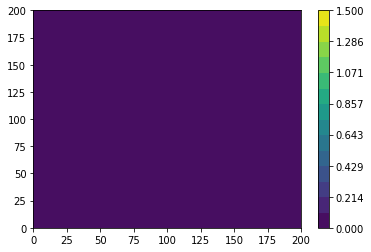

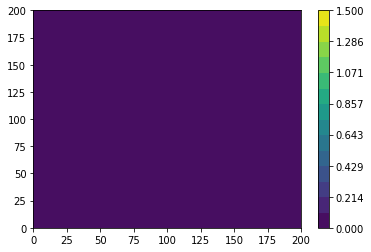

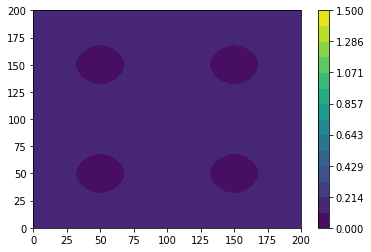

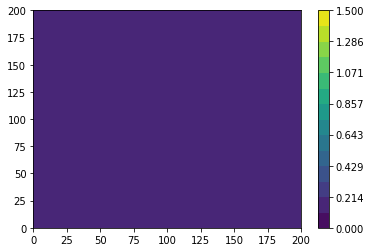

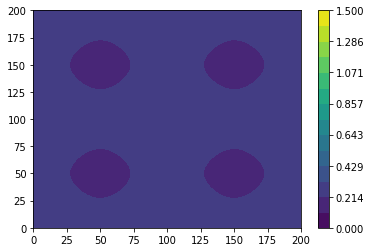

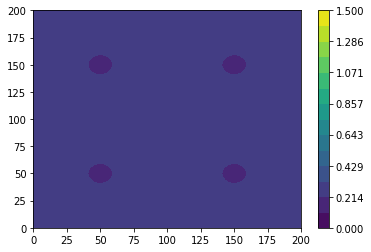

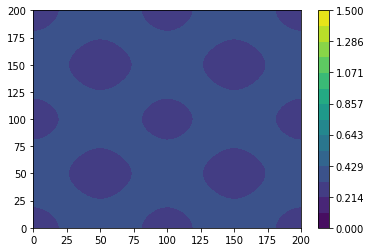

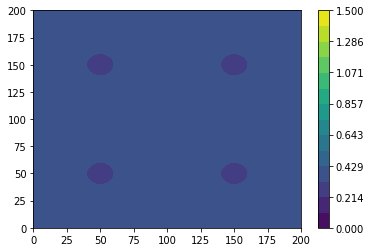

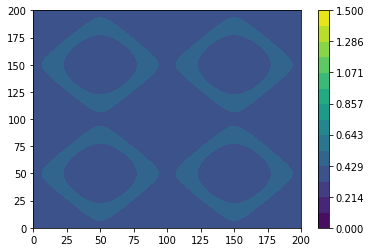

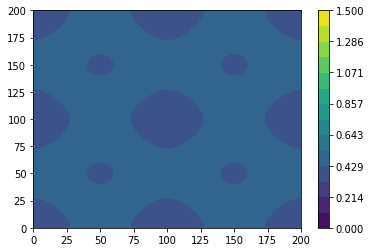

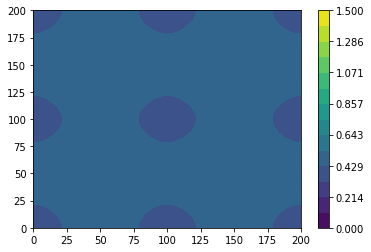

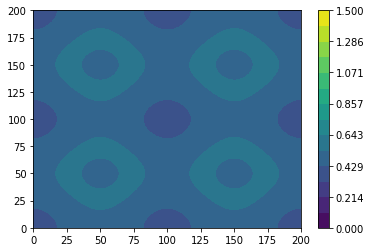

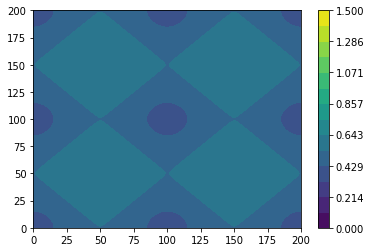

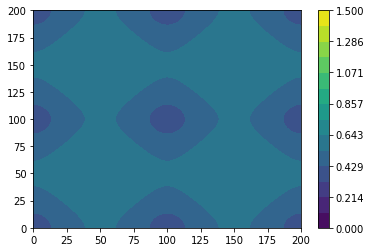

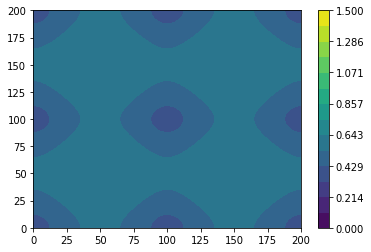

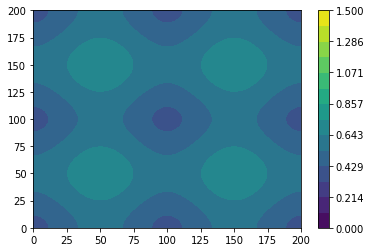

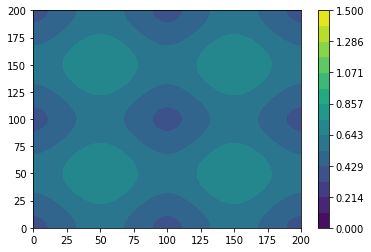

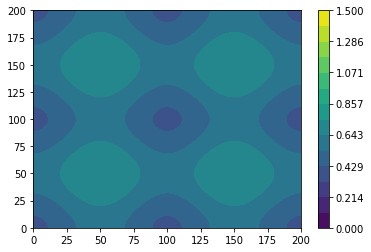

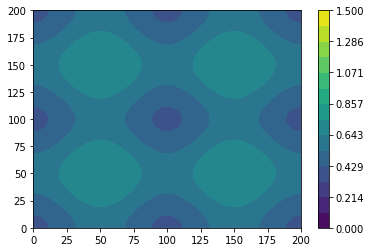

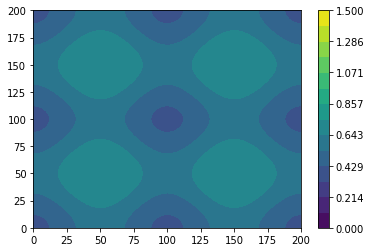

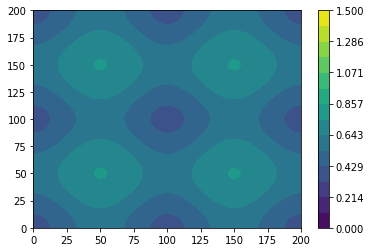

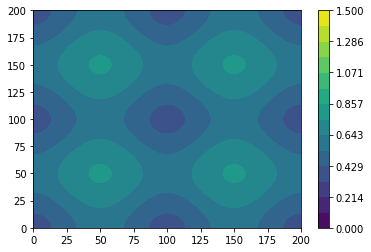

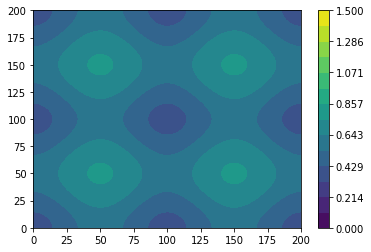

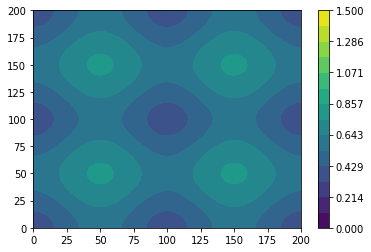

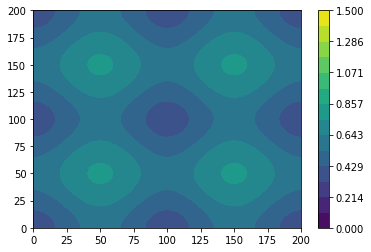

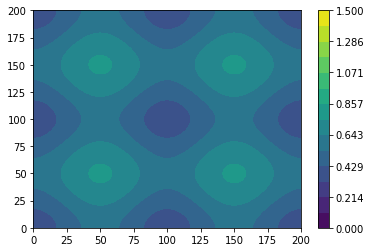

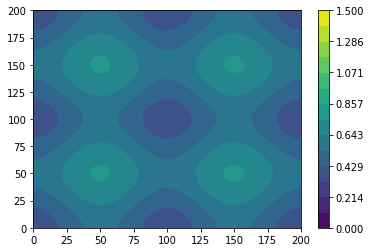

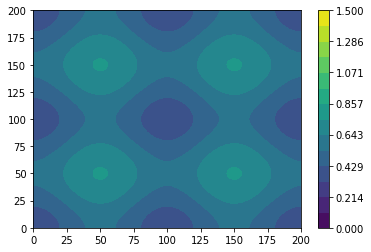

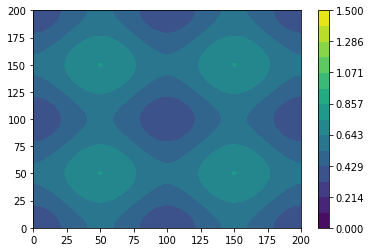

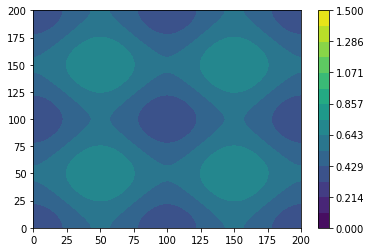

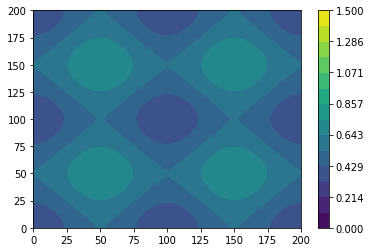

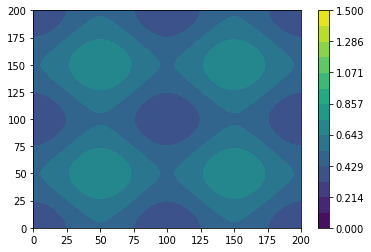

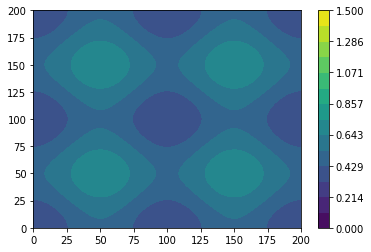

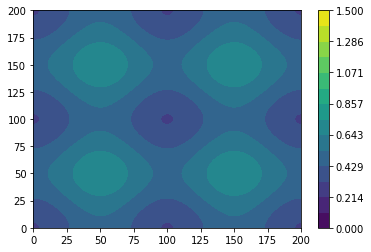

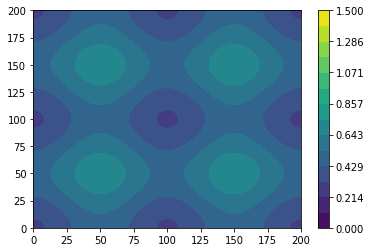

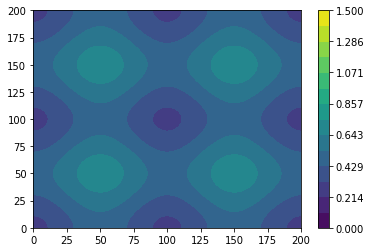

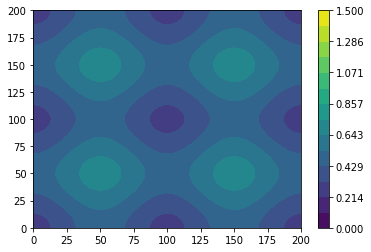

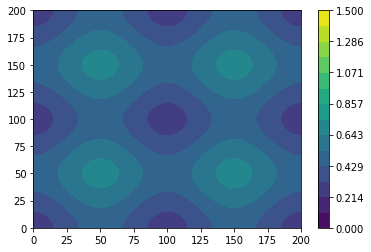

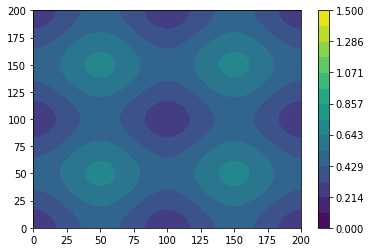

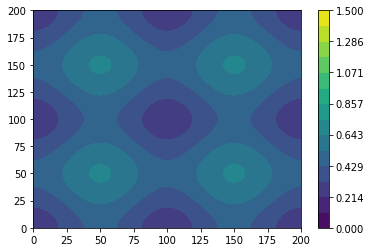

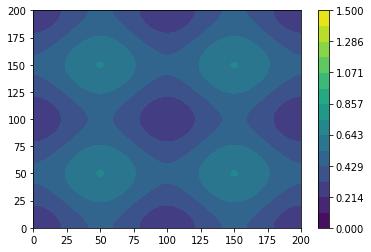

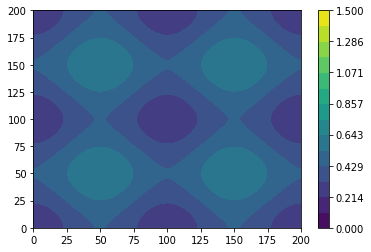

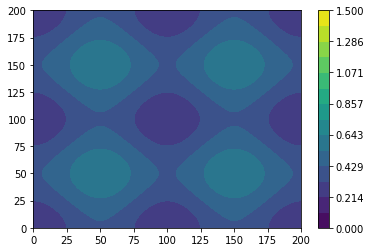

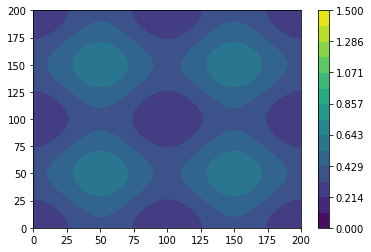

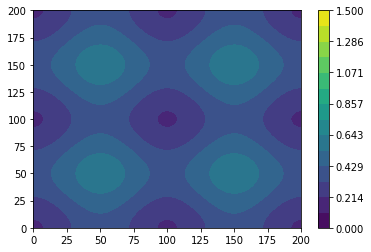

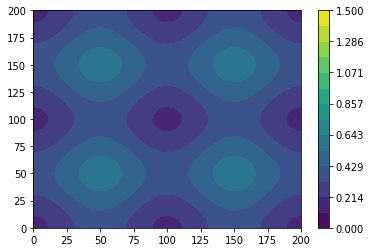

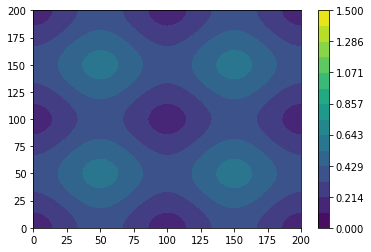

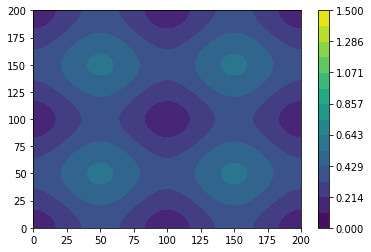

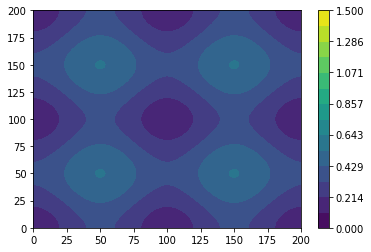

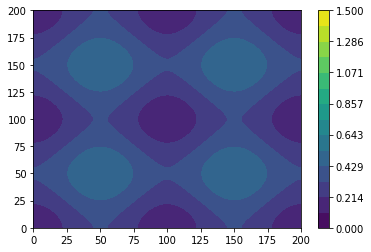

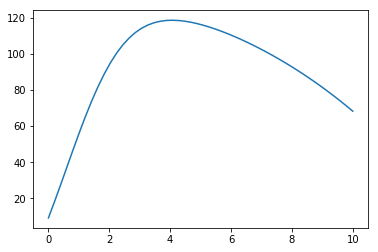

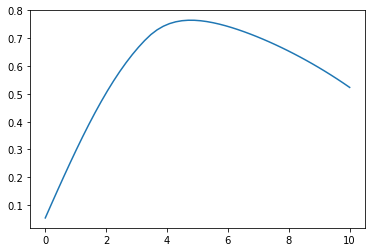

In [2]:
%matplotlib inline
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
set_log_level(ERROR) 

def param_update(nonlinear_solver):
    prm1 = nonlinear_solver.parameters
    prm1['newton_solver']['absolute_tolerance'] = 1E-9
    prm1['newton_solver']['relative_tolerance'] = 1E-9
    prm1['newton_solver']['maximum_iterations'] = 100
    prm1['newton_solver']['relaxation_parameter'] = 1.0
    prm1['newton_solver']['linear_solver'] = 'gmres'
    prm1['newton_solver']['preconditioner'] = 'ilu'
    prm1['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-9
    prm1['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-9
    prm1['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    prm1['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    return None

# Prepare a mesh
N = 200
mesh = RectangleMesh(Point(-100., -100.0), Point(100.0, 100.0), N,N)
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
lin_hyp   = 0                # Linear/Nonlinear
D0        = 1.               # Diffusion
k0        = 1.               # Growth
beta      = 1.               # Relates elasticity to number of cells
gammaD    = 0.               # Relates diffusion to elasticity
t         = 0.               # initial time
T         = 10.0             # final time 
dt        = .2               # Time step size
num_steps = int(T/dt)        # number of time steps
theta     = 50970.           # carrying capacity - normalize data by this
mu        = .42              # bulk shear modulus (kPa)
nu        = .45              # poisson's ratio
lmbda     = 2*mu*nu/(1-2*nu) # lame parameter
k         = project(k0, V)  

# Define strain and vonmises functions
I = Identity(2)  # Identity tensor
def E(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
def vonmises(u):
    s = sigma(u) - (1./2)*tr(sigma(u))*I  # deviatoric stress
    von_Mises = sqrt(3./2*inner(s, s))
    return project(von_Mises, V)

# Set up elasticity problem
U    = VectorFunctionSpace(mesh,'Lagrange',1)
def boundary(x, on_boundary):
    return on_boundary
bc   = DirichletBC(U, Constant((0.,0.)), boundary)
v    = TestFunction(U)

# Initial Condition
p_n  = Expression(".1*(cos(pi*x[0]/50)+cos(pi*x[1]/50)+exp(.17*t)+2)",degree=5,t=t)
p_n  = interpolate(p_n,V)
plt.figure()
levs = np.linspace(0,1.5,15)
f = plt.contourf(p_n.compute_vertex_values().reshape([N+1,N+1]),levs)
plt.colorbar(mappable=f)

ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
parameters['form_compiler']['quadrature_degree'] = 2
parameters['form_compiler']['cpp_optimize'] = True
parameters['krylov_solver']['nonzero_initial_guess'] = True

# Linear/Nonlinear formulations
if lin_hyp == 0:
    def sigma(u):
        s = 2*mu*E(u)+lmbda*tr(E(u))*I
        return s
    u    = TrialFunction(U)
    a = inner(2*mu*E(u)+lmbda*tr(E(u))*I,E(v))*dx
    L = inner(2*beta*p_n*I*(mu+lmbda),E(v))*dx
    u    = Function(U)
    def mech():
    # Next time step
        solve(a == L, u, bc, 
                  form_compiler_parameters=ffc_options)
        return u
else:
    def sigma(u):
        F = I + grad(u)             # Deformation gradient
        B = F*F.T
        C = F.T*F
        J = det(F)
        I1 = tr(C)
        s = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
        return s
    def sigma_form(u, phi):
        F = I + grad(u)             # Deformation gradient
        Fs = F/(1+beta*phi)
        Bs = Fs*Fs.T
        Js  = det(Fs)
        return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)
    u           = Function(U)
    du          = TrialFunction(U)
    F_HE        = inner(sigma_form(u, p_n), E(v))*dx
    J_HE        = derivative(F_HE,u,du)
    problem_HE  = NonlinearVariationalProblem(F_HE, u, bc, J=J_HE,form_compiler_parameters=ffc_options)
    solver_HE   = NonlinearVariationalSolver(problem_HE)
    param_update(solver_HE)
    def mech():
        solver_HE.solve()
        return u

# First iteration solving for displacement, and using the von mises stress field for D
disp = mech()
vm   = vonmises(disp)
D    = project(D0*exp(-gammaD*vm),V)

# Set up Reaction Diffusion problem
dp   = TrialFunction(V)
p    = Function(V)
q    = TestFunction(V)

l2err  = []
linfty = []
for n in range(num_steps):
    
    # RD Analytical solution
    u_D  = Expression(".1*(cos(pi*x[0]/50)+cos(pi*x[1]/50)+exp(.17*t)+2)",degree=5,t=t)
    u_E  = interpolate(u_D,V)
    Lu   = Expression(".017*exp(.17*t)+.1*pow(pi/50,2)*(cos(pi*x[0]/50)+cos(pi*x[1]/50))",degree=5,t=t)
    Lu_1 = interpolate(Lu,V)
    R    = Lu_1-.1*u_E*(1-u_E)

    # Set up reaction-diffusion problem
    F_RD       = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p_n)*q*dx -R*q*dx 
    J_RD       = derivative(F_RD,p) 
    problem_RD = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
    solver_RD  = NonlinearVariationalSolver(problem_RD)
    param_update(solver_RD)

    # Solve and update 
    solver_RD.solve()
    p_n.assign(p)
    disp = mech()
    vm   = vonmises(disp)
    D    = project(D0*exp(-gammaD*vm),V)
    
    # Calculate error
    diff = np.abs(u_E.compute_vertex_values()-p_n.compute_vertex_values())
    l2err.append(errornorm(p_n,u_E,'L2'))
    linfty.append(np.max(diff))
    plt.figure()
    f = plt.contourf(diff.reshape([N+1,N+1]),np.linspace(0,1.5,15))
    plt.colorbar(mappable=f)
    
    # Next time step
    t += dt

plt.figure()
plt.plot(np.linspace(0.,T,num_steps),l2err)
plt.figure()
plt.plot(np.linspace(0.,T,num_steps),linfty)

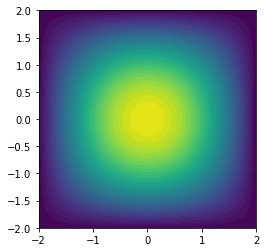

In [3]:
from fenics import *
import time
set_log_level(ERROR) 

T = 2.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)
u_n = interpolate(u_0, V)
plot(u_n)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    plot(u)

    # Update previous solution
    u_n.assign(u)
